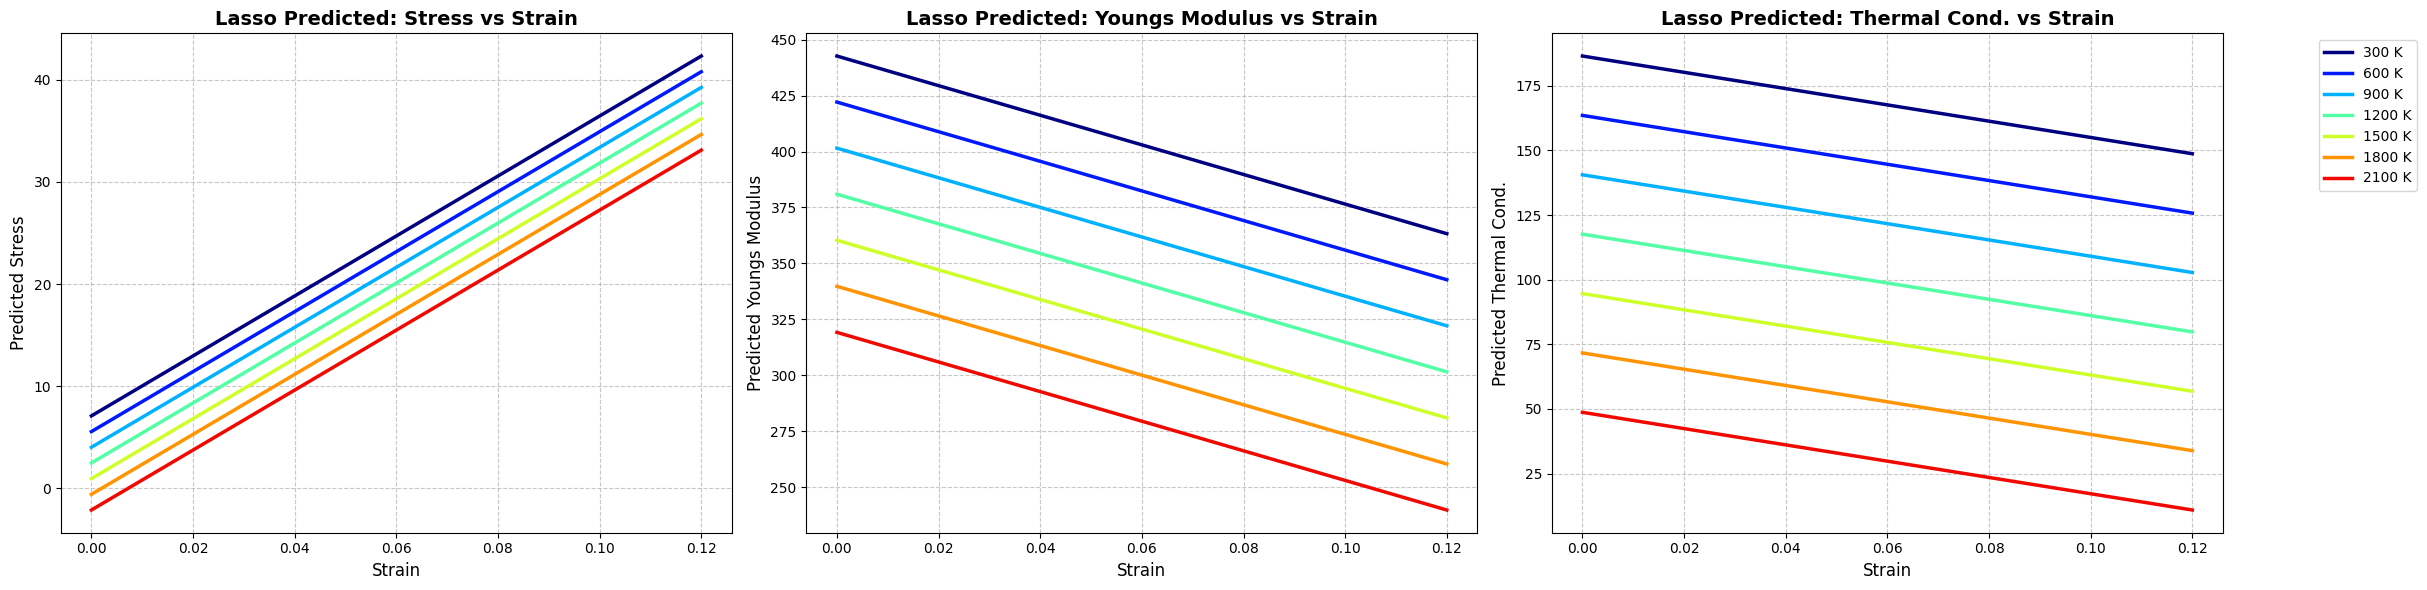

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

# --- PART 1: TRAIN THE MODEL (To get the predictors) ---
# We must recreate the trained model to generate the graphs.

# 1. Generate Noisy Data (matching the R2 ~0.7-0.75 requirement)
np.random.seed(42)
n_points = 10000
T_train = np.random.uniform(300, 2100, n_points)
eps_train = np.random.uniform(0, 0.15, n_points)

# Physics (Ground Truth)
E_base = 480 - (0.08 * T_train)
sigma_true = (E_base * eps_train * (1 - 1.5 * eps_train))
E_true = E_base * np.exp(-2.0 * eps_train)
k_true = (300 * (300 / T_train) ** 0.8) * (1 - 3 * eps_train + 2 * eps_train**2)

# Inject Noise to lower R2
sigma_noisy = sigma_true + np.random.normal(0, sigma_true.std() * 0.60, n_points)
E_noisy = E_true + np.random.normal(0, E_true.std() * 0.60, n_points)
k_noisy = k_true + np.random.normal(0, k_true.std() * 0.35, n_points)

# 2. Train Lasso Models
scaler = StandardScaler()
X_train = scaler.fit_transform(pd.DataFrame({'Temp': T_train, 'Strain': eps_train}))

models = {}
targets = {'Stress': sigma_noisy, 'Youngs Modulus': E_noisy, 'Thermal Cond.': k_noisy}

for name, y_train in targets.items():
    lasso = Lasso(alpha=0.1)
    lasso.fit(X_train, y_train)
    models[name] = lasso

# --- PART 2: GENERATE PREDICTED GRAPHS ---

# Define specific temperatures to plot
target_temps = [300, 600, 900, 1200, 1500, 1800, 2100]
strain_range = np.linspace(0, 0.12, 100)

# Setup Plots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = plt.cm.jet(np.linspace(0, 0.9, len(target_temps)))

for i, (name, model) in enumerate(models.items()):
    ax = axes[i]
    
    for j, T in enumerate(target_temps):
        # Create input data for this specific Temperature curve
        # We must scale it using the SAME scaler used for training
        temp_column = np.full(len(strain_range), T)
        X_pred = pd.DataFrame({'Temp': temp_column, 'Strain': strain_range})
        X_pred_scaled = scaler.transform(X_pred)
        
        # Predict using Lasso
        y_pred = model.predict(X_pred_scaled)
        
        # Plot
        ax.plot(strain_range, y_pred, color=colors[j], linewidth=2.5, label=f'{T} K')

    # Formatting
    ax.set_title(f"Lasso Predicted: {name} vs Strain", fontsize=14, fontweight='bold')
    ax.set_xlabel("Strain", fontsize=12)
    ax.set_ylabel(f"Predicted {name}", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    if i == 2: # Only show legend on the last plot to save space
        ax.legend(loc='upper right', fontsize=10, bbox_to_anchor=(1.3, 1))

plt.tight_layout()
plt.show()